In [1]:
import pandas as pd
import re
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!wget -q https://download.baderlab.org/PathwayCommons/PC2/v12/PathwayCommons12.All.hgnc.txt.gz

In [3]:
!gunzip PathwayCommons12.All.hgnc.txt.gz

In [4]:
# Load PathwayCommons data
path = Path("/Users/cenkcelik/Downloads/PathwayCommons12.All.hgnc.txt")
paths = pd.read_csv(path, sep='\t')

In [5]:
# Filter rows with non-empty pathway names
paths = paths[paths["PATHWAY_NAMES"].notna() & (paths["PATHWAY_NAMES"] != "")]

# Explode multiple pathway names into rows
paths = paths.assign(PATHWAY_NAMES=paths["PATHWAY_NAMES"].str.split(";")).explode("PATHWAY_NAMES")

# Remove duplicates
paths = paths.drop_duplicates()

# Concatenate gene pairs by pathway
paths_sum = (
    paths[["PARTICIPANT_A", "PARTICIPANT_B", "PATHWAY_NAMES"]]
    .groupby("PATHWAY_NAMES")
    .agg(lambda x: ", ".join(pd.unique(x)))
    .reset_index()
)

In [6]:
# Remove CHEBI (non-gene) symbols
def clean_genes(gene_str):
    genes = list(set(re.split(r",\s*", gene_str)))
    return ", ".join([g for g in genes if not g.startswith("CHEBI:")])

In [7]:
paths_sum["gene_list"] = paths_sum.apply(
    lambda row: clean_genes(f"{row['PARTICIPANT_A']}, {row['PARTICIPANT_B']}"), axis=1
)
paths_sum = paths_sum[paths_sum["gene_list"] != ""]

# Count unique genes per pathway
paths_sum["gene_lengths"] = paths_sum["gene_list"].apply(lambda x: len(set(re.split(r",\s*", x))))

# Filter by gene list size
paths_sum = paths_sum[(paths_sum["gene_lengths"] >= 4) & (paths_sum["gene_lengths"] < 475)]

In [8]:
# Define hallmark extraction function
def extract_hallmark(paths_df, keywords, label, exact=True, pathway_names=None):
    if pathway_names:
        sub = paths_df[paths_df["PATHWAY_NAMES"].isin(pathway_names)].copy()
    else:
        regex = "|".join([f"\\b{k}\\b" if exact else k for k in keywords])
        sub = paths_df[paths_df["PATHWAY_NAMES"].str.contains(regex, case=False, na=False)].copy()
    sub["hallmark"] = label
    genes = set()
    sub["gene_list"].str.split(", ").apply(genes.update)
    return sub, pd.DataFrame({"genes": list(genes), "H": label})

In [9]:
# Define hallmark keywords or pathway names
hallmark_defs = {
    "H1": dict(keywords=[
        "Cell Cycle", "Cell Division", "Growth Hormone", "EGF", "ERBB", "FGF", "PI3", "MAPK", "signaling by AKT1",
        "RAS", "MTOR", "MYC", "CDK2", "JAK/STAT", "STAT3", "signaling by FGFR1", "signaling by FGFR2",
        "signaling by FGFR3", "signaling by FGFR4"
    ]),
    "H2": dict(keywords=[
        "RB1", "P53", "APC", "SMAD4", "Cyclin", "Degradation of Cyclin", "Inactivation of Cyclin", "Checkpoint"
    ]),
    "H3": dict(pathways=[
        "PD-1 signaling", "Negative regulators of RIG-I/MDA5 signaling",
        "CTLA4 inhibitory signaling", "TRAIL signaling pathway"
    ]),
    "H4": dict(keywords=["Telomere", "Recognition of DNA damage"]),
    "H5": dict(keywords=["inflammation", "SMAD", "chemokine", "cytokine", "interferon", "IFN"]),
    "H6": dict(keywords=["EMT", "E-Cadherin", "Metalloprot", "integrin", "Hedgehog signaling"]),
    "H7": dict(keywords=[
        "Wnt Signaling Pathway", "Hypoxia", "Angiogen", "Tie2", "PDGF", "NOTCH", "HIF", "VEGF"
    ]),
    "H8": dict(keywords=["Dna repair", "DNA damage"]),
    "H9": dict(pathways=[
        "ERK/MAPK targets", "Calcineurin activates NFAT",
        "Stabilization and accumulation of cytoplasmic beta-catenin (Mammal) ( Mammalian Wnt signaling pathway Diagram )",
        "ATF4 activates genes in response to endoplasmic reticulum stress"
    ]),
    "H10": dict(keywords=[
        "HIF", "Glycolysis", "Insulin", "Warburg Effect", "AMPK", "Energy", "Mitochondrial Beta-Oxidation"
    ]),
    "H11": dict(keywords=["Senescence"]),
    "H12": dict(keywords=["histones", "chromatin"]),
    "H13": dict(pathways=[
        "Transcriptional regulation of pluripotent stem cells",
        "POU5F1 (OCT4), SOX2, NANOG repress genes related to differentiation",
        "Wnt signaling pathway",
        "Hedgehog signaling pathway",
        "Signaling events mediated by Stem cell factor receptor (c-Kit)"
    ])
}

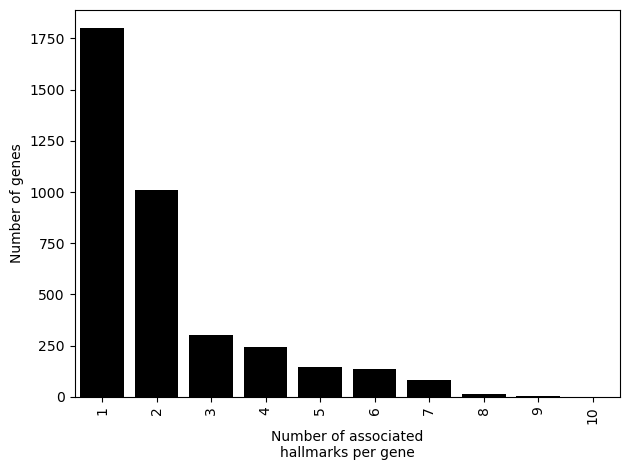

In [10]:
# Extract all hallmark genes and paths
all_genes = []
all_paths = []

for h, defs in hallmark_defs.items():
    if "keywords" in defs:
        p, g = extract_hallmark(paths_sum, defs["keywords"], h)
    else:
        p, g = extract_hallmark(paths_sum, [], h, pathway_names=defs["pathways"])
    all_genes.append(g)
    all_paths.append(p)

H_genes = pd.concat(all_genes, ignore_index=True)
paths_final = pd.concat(all_paths, ignore_index=True)

# Plot: Number of associated hallmarks per gene
gene_counts = H_genes.groupby("genes")["H"].nunique().reset_index(name="HAGs")
sns.countplot(x="HAGs", data=gene_counts, color="black")
plt.ylabel("Number of genes")
plt.xlabel("Number of associated\nhallmarks per gene")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

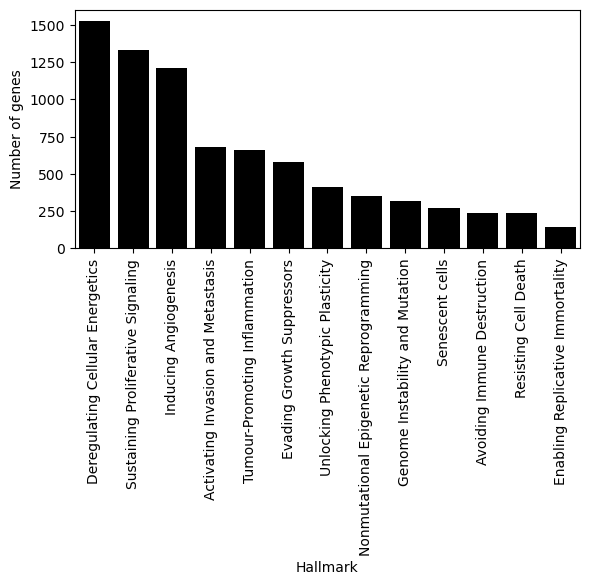

In [11]:
# Plot number of genes and pathways per hallmark
hallmark_names = pd.DataFrame({
    "hallmark": [f"H{i}" for i in range(1, 14)],
    "hallmark_name": [
        "Sustaining Proliferative Signaling", "Evading Growth Suppressors", "Avoiding Immune Destruction",
        "Enabling Replicative Immortality", "Tumour-Promoting Inflammation", "Activating Invasion and Metastasis",
        "Inducing Angiogenesis", "Genome Instability and Mutation", "Resisting Cell Death",
        "Deregulating Cellular Energetics", "Senescent cells", "Nonmutational Epigenetic Reprogramming",
        "Unlocking Phenotypic Plasticity"
    ]
})

# Join for plotting
n_genes = H_genes.groupby("H").size().reset_index(name="n_genes")
n_genes = n_genes.rename(columns={"H": "hallmark"})
n_genes = pd.merge(n_genes, hallmark_names, on="hallmark")
n_genes = n_genes.sort_values("n_genes", ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=n_genes, x="hallmark_name", y="n_genes", color="black")
plt.xticks(rotation=90)
plt.xlabel("Hallmark")
plt.ylabel("Number of genes")
plt.tight_layout()
plt.show()

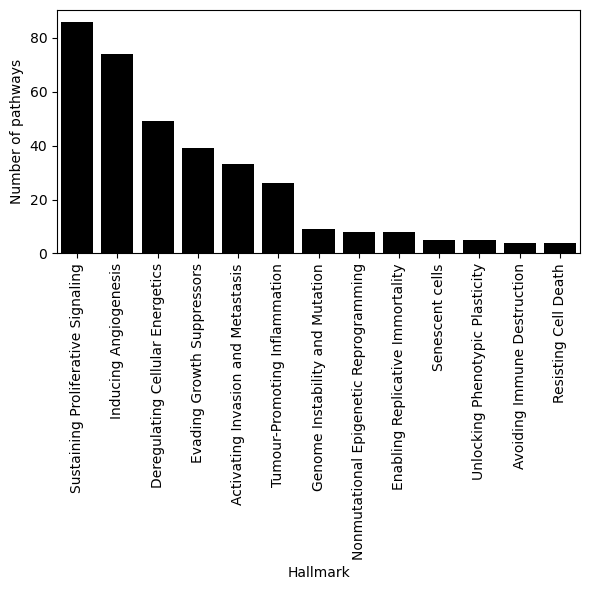

In [12]:
n_paths = paths_final.groupby("hallmark").size().reset_index(name="n_pathways")
n_paths = pd.merge(n_paths, hallmark_names, on="hallmark")
n_paths = n_paths.sort_values("n_pathways", ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=n_paths, x="hallmark_name", y="n_pathways", color="black")
plt.xticks(rotation=90)
plt.xlabel("Hallmark")
plt.ylabel("Number of pathways")
plt.tight_layout()
plt.show()

In [13]:
# convert all_genes to a dictionary where H* will be the keys and the values will be the genes
H_genes_dict = {}
for h, defs in hallmark_defs.items():
    if "keywords" in defs:
        p, g = extract_hallmark(paths_sum, defs["keywords"], h)
    else:
        p, g = extract_hallmark(paths_sum, [], h, pathway_names=defs["pathways"])
    H_genes_dict[h] = list(g["genes"].unique())

In [14]:
# length of each hallmark
for h, genes in H_genes_dict.items():
    print(f"{h}: {len(genes)}")

H1: 1332
H2: 580
H3: 237
H4: 146
H5: 661
H6: 683
H7: 1210
H8: 321
H9: 235
H10: 1527
H11: 270
H12: 350
H13: 411


In [15]:
# save the dictionary to a pickle file
import pickle
with open("hallmarks_genelists.pkl", "wb") as f:
    pickle.dump(H_genes_dict, f)

In [16]:
hallmark_names

,hallmark,hallmark_name
0,H1,Sustaining Proliferative Signaling
1,H2,Evading Growth Suppressors
2,H3,Avoiding Immune Destruction
3,H4,Enabling Replicative Immortality
4,H5,Tumour-Promoting Inflammation
5,H6,Activating Invasion and Metastasis
6,H7,Inducing Angiogenesis
7,H8,Genome Instability and Mutation
8,H9,Resisting Cell Death
9,H10,Deregulating Cellular Energetics
